In [1]:
sys.path.append("../")
import os
import utils
import plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib.patches as mpatches
import seaborn as sns
from collections import defaultdict
import os
import json
from matplotlib import font_manager as fm, rcParams
rcParams["legend.frameon"] = False
set1_colors = sns.color_palette('Set1')
policies = ("No vaccines", "Population-based", "Infected-based", "Age-based", "Contact-based")
renamer = {"deaths": "Fatalities", "infected": "Infected", "weighted": "Weighted", "yll": "YLL", "fatalities": "Fatalities", "YLL": "YLL", "fatalities (seeded)": "Fatalities (seeded)", "fatalities (non-seeded)": "Fatalities (non-seeded)", "deaths (seeded)": "Fatalities (seeded)", "deaths (non-seeded)": "Fatalities (non-seeded)", "infected (seeded)": "Infected (seeded)", "infected (non-seeded)": "Infected (non-seeded)", "weighted (seeded)": "Weighted (seeded)", "weighted (non-seeded)": "Weighted (non-seeded)", "yll (seeded)": "YLL (seeded)", "YLL (seeded)": "YLL (seeded)", "yll (non-seeded)": "YLL (non-seeded)", "YLL (non-seeded)": "YLL (non-seeded)"}
paired = sns.color_palette("Paired")
run_colors = {
    "deaths (non-seeded)": paired[0],
    "infected (non-seeded)": paired[4],
    "weighted (non-seeded)": paired[2],
    "yll (non-seeded)": paired[6],
    "deaths (seeded)": paired[1],
    "infected (seeded)": paired[5],
    "weighted (seeded)": paired[3],
    "yll (seeded)": paired[7]
}
tab10 = sns.color_palette("tab10")
objective_colors = {
    "deaths": tab10[0],
    "infected": tab10[3],
    "weighted": tab10[2],
    "yll": tab10[1]
}
policy_colors = sns.color_palette("Set1")

In [2]:
def read_all_results(dir_path):
    paths = os.listdir(dir_path)
    runs = {}
    for path in paths:
        params = utils.load_json(f'{dir_path+path}/run_params.json')
        obj = params['objective']
        random = bool(params['random_individuals'])
        last_gen = sorted(map(lambda x: x.split("_"), 
                        os.listdir(f"{dir_path+path}/individuals/")), 
                        key=lambda x: int(x[1].split(".")[0]))[-1][-1][:-4]
        last_gen = int(last_gen)
        run_name = f"{obj} ({'non-seeded' if random else 'seeded'})"
        runs[run_name] = {"path": path, "last_gen": last_gen, "seeded": not random, "objective": obj}
    return runs

In [3]:
dir_path = "../results/ga/"
runs = read_all_results(dir_path)
run_info = pd.DataFrame(runs).T.reset_index().sort_values(["seeded", "index"]).rename({"index": "run_name"}, axis=1).set_index(pd.Index(np.arange(8)))
run_names = list(run_info['run_name'])
run_info

,run_name,path,last_gen,seeded,objective
0,deaths (non-seeded),GA_2021_06_07_09_53_00,165,False,deaths
1,infected (non-seeded),GA_2021_06_06_13_15_12,201,False,infected
2,weighted (non-seeded),GA_2021_06_06_17_23_47,201,False,weighted
3,yll (non-seeded),GA_2021_06_06_13_15_38,201,False,yll
4,deaths (seeded),GA_2021_06_07_09_43_05,185,True,deaths
5,infected (seeded),GA_2021_06_06_13_13_38,201,True,infected
6,weighted (seeded),GA_2021_06_06_13_11_53,201,True,weighted
7,yll (seeded),GA_2021_06_07_09_48_01,183,True,yll


## Generation Means

In [4]:
def get_result_means(run_name):
    generation_scores = os.listdir(dir_path+runs[run_name]['path']+"/final_scores/")
    final_scores = []
    for score in sorted(generation_scores, key=lambda x: int(x.split("_")[2][:-4])):
        final_scores.append(utils.read_pickle(dir_path+runs[run_name]['path']+"/final_scores/"+score))
    generation_means = defaultdict(list)
    for gen_scores in final_scores:
        gen_individual_means = defaultdict(list)
        for individual in gen_scores.keys():
            for objective, scores in gen_scores[individual].items():
                gen_individual_means[objective].append(np.mean(scores))
        for objective, scores in gen_individual_means.items():
            generation_means[objective].append(np.mean(scores))
    generation_means = dict(generation_means)
    result_means = pd.DataFrame(generation_means)
    result_means.index.rename("generation", inplace=True)
    return result_means, final_scores

In [5]:
gen_means = {}
final_scores = {}
for run_name in run_names:
    gen_means[run_name], final_scores[run_name] = get_result_means(run_name)

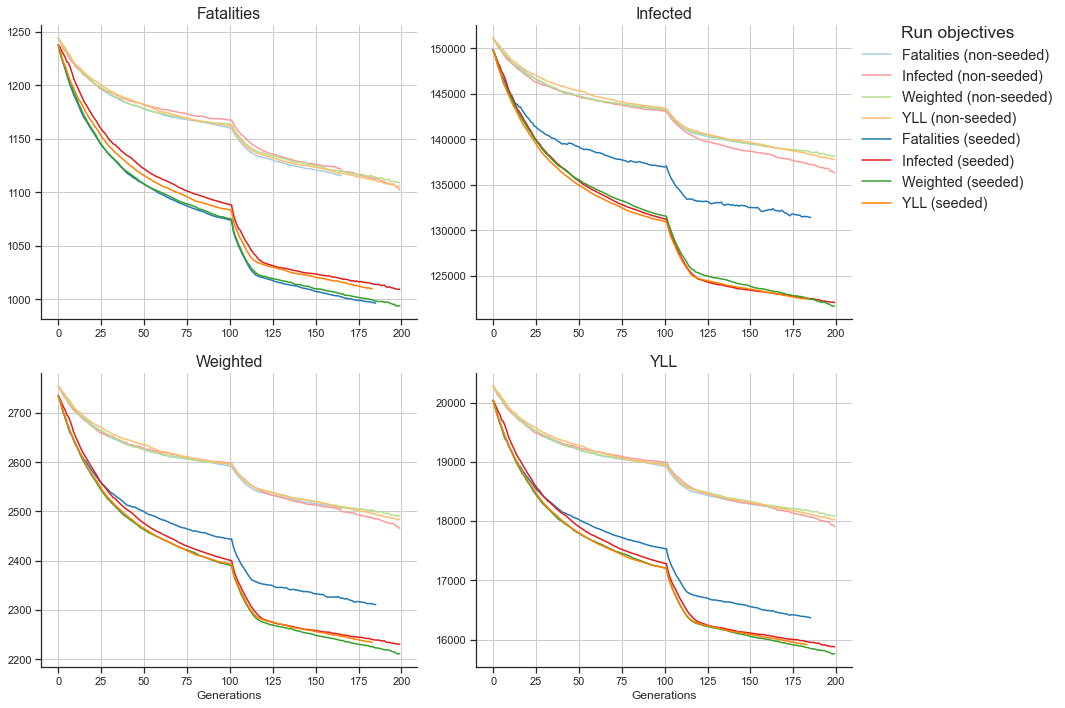

In [33]:
max_generations = 200
sns.set(font_scale=1)
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(15,10))
for i, main_objective in enumerate(["deaths", "infected", "weighted", "yll"]):
    ax = axs[i//2][i%2]
    for run in gen_means:
        gen_means[run][main_objective][:max_generations].plot(label=renamer[run], color=run_colors[run], ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid()
    if i > 1: 
        ax.set_xlabel("Generations", fontsize=12)
    else:
        ax.set_xlabel("")
    ax.set_title(renamer[main_objective], fontsize=16)
plt.legend(bbox_to_anchor=(1.57, 2.22), fontsize='large', title="Run objectives", title_fontsize='x-large', fancybox=False)
plt.tight_layout()
plt.subplots_adjust(hspace=0.18)
plt.savefig("../plots/GA/mean_generation_score.png", dpi=200)
plt.show()

## Best individual

In [7]:
def get_best_individual_results(run_name):
    filenames = os.listdir(dir_path+runs[run_name]['path']+"/best_individuals/")
    best_individuals = []
    for individual in sorted(filenames, key=lambda x: int(x.split("_")[2][:-4])):
        best_individuals.append(utils.read_pickle(dir_path+runs[run_name]['path']+"/best_individuals/"+individual))

    best_individual_scores = {gen: {"individual": None,"deaths":None, "infected":None, "weighted":None, "yll": None}for gen in range(len(best_individuals))}
    for i, individual in enumerate(best_individuals):
        best_individual_scores[i]["individual"] = individual
        for obj in ["deaths", "infected", "weighted", "yll"]:
            best_individual_scores[i][obj] = np.mean(final_scores[run_name][i][individual.ID][obj])
    results = pd.DataFrame(dict(best_individual_scores)).T
    results.index.rename("generation", inplace=True)
    return results

In [8]:
best_individual_results = {}
for run_name in run_names:
    best_individual_results[run_name] = get_best_individual_results(run_name)

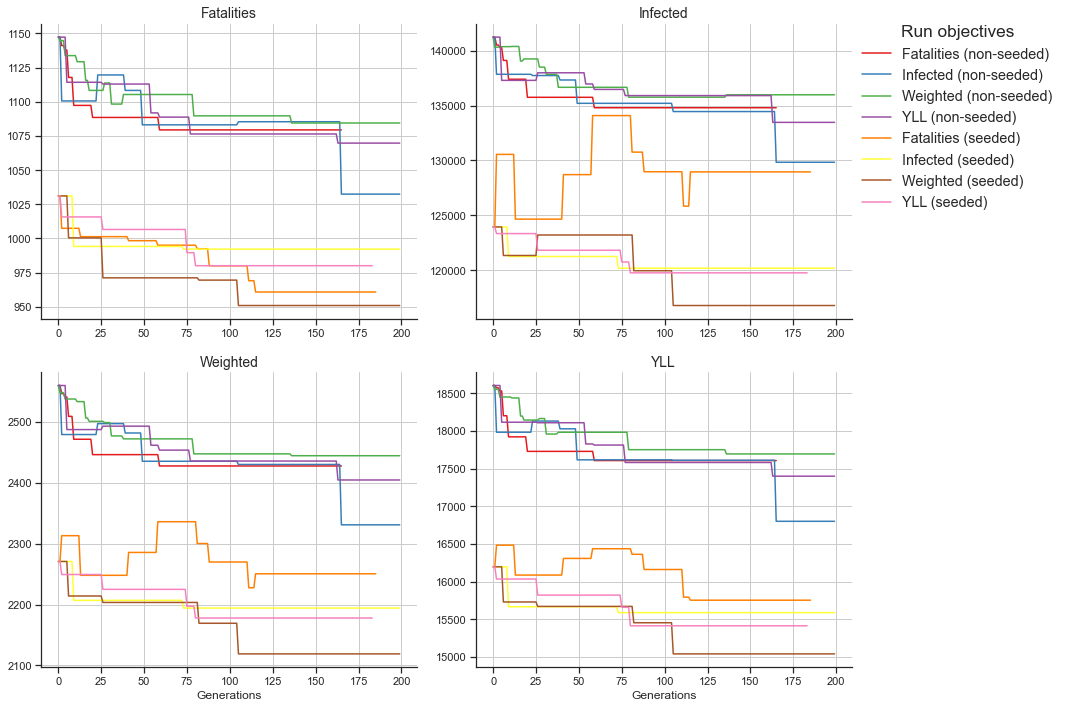

In [9]:
max_generations = 200
sns.set(font_scale=1)
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(15,10))
for i, main_objective in enumerate(["deaths", "infected", "weighted", "yll"]):
    ax = axs[i//2][i%2]
    for j, run in enumerate(gen_means):
        best_individual_results[run][main_objective][:max_generations].plot(label=renamer[run], color=colors[j], ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid()
    if i > 1: 
        ax.set_xlabel("Generations", fontsize=12)
    else:
        ax.set_xlabel("")
    ax.set_title(renamer[main_objective], fontsize=14)
plt.legend(bbox_to_anchor=(1.57, 2.22), fontsize='large', title="Run objectives", title_fontsize='x-large')
plt.tight_layout()
plt.subplots_adjust(hspace=0.18)
plt.savefig("../plots/GA/best_individuals_score.png", dpi=200)
plt.show()

# Solutions

In [67]:
def get_individual(run_name, gen):
    return utils.read_pickle(f"{dir_path}{runs[run_name]['path']}/best_individuals/best_individual_{gen}.pkl")

def load_pop(run_name):
    pop = utils.read_pickle(f"{dir_path}{runs[run_name]['path']}/individuals/individuals_{runs[run_name]['last_gen']}.pkl")
    return pop

def plot_weighted_policy(ax, weights, ylim, legend=True):
    pd.DataFrame(dict(zip(policies, weights)), index=["Percent"]).plot(kind='bar', color=policy_colors, width=3, ax=ax, legend=False)
    for rect in ax.patches:
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        label_text = f'{height*100:.0f}%'
        label_x = x + width / 2 + 0.01
        label_y = y + height + 0.03
        if width > 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid()
    ax.get_xaxis().set_visible(False)
    ax.set_ylim(0, ylim)
    if legend: ax.legend()

def get_aggregated_etp(pop):
    etp = (sum([i.genes for i in pop])/len(pop)).sum(axis=0).sum(axis=0)
    etp /= sum(etp)
    return etp

def plot_accumulated_etp(etps, ylim):
    sns.set(font_scale=1.1)
    sns.set_style("ticks")
    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15,10), sharey=True, sharex=True)
    for i, run_name in enumerate(etps):
        ax = axs[i//2][i%2]
        plot_weighted_policy(ax, etps[run_name], ylim, legend=False)
        ax.set_title(f"Run objective: {renamer[run_name]}", fontsize=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.43, 3))
    plt.show()

def plot_etp(genes, ylim):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,10), sharey=True, sharex=True)
    for i, trend in enumerate(["Up", "Down", "Neutral"]):
        for trend_count in range(3):
            ax = axs[trend_count][i]
            plot_weighted_policy(ax, genes[i][trend_count], ylim, legend=False)
            if i == 0: 
                ax.set_ylabel(trend_count+1, fontsize=16, rotation=0)
                ax.yaxis.set_label_coords(-0.2,0.5)
            if trend_count == 0: ax.set_title(trend, fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.7, 3.5))
    plt.show()

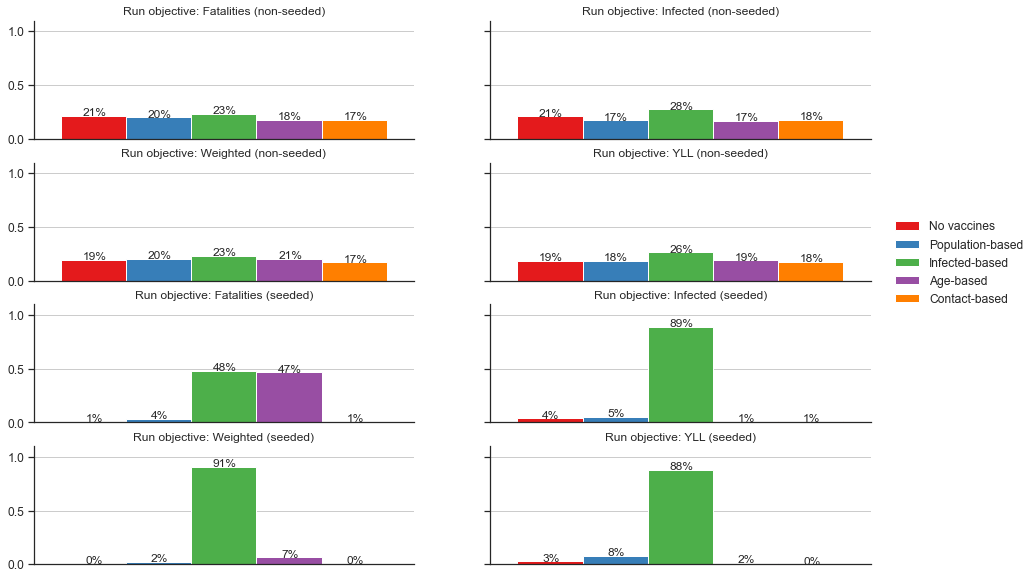

In [11]:
pops = {}
for run_name in run_names:
    pops[run_name] = load_pop(run_name)

top_individuals = 30
accumulated_etps = {}
for run_name in run_names:
    accumulated_etps[run_name] = get_aggregated_etp(pops[run_name][:top_individuals])

plot_accumulated_etp(accumulated_etps, 1.1)

### Best individual

In [12]:
run_info

,run_name,path,last_gen,seeded,objective
0,deaths (non-seeded),GA_2021_06_07_09_53_00,165,False,deaths
1,infected (non-seeded),GA_2021_06_06_13_15_12,201,False,infected
2,weighted (non-seeded),GA_2021_06_06_17_23_47,201,False,weighted
3,yll (non-seeded),GA_2021_06_06_13_15_38,201,False,yll
4,deaths (seeded),GA_2021_06_07_09_43_05,185,True,deaths
5,infected (seeded),GA_2021_06_06_13_13_38,201,True,infected
6,weighted (seeded),GA_2021_06_06_13_11_53,201,True,weighted
7,yll (seeded),GA_2021_06_07_09_48_01,183,True,yll


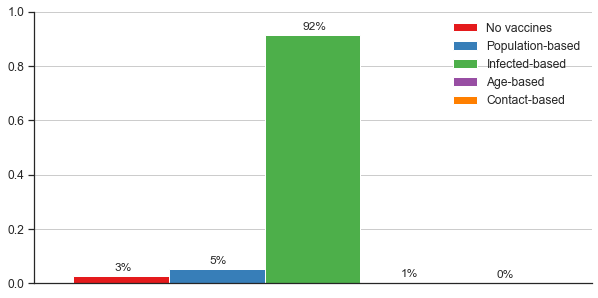

In [13]:
run_name  = run_names[5]
gen = runs[run_name]['last_gen']
individual = get_individual(run_name, gen)
weights = individual.genes.sum(axis=0).sum(axis=0)
weights /= sum(weights)
fig, ax = plt.subplots(figsize=(10,5))
plot_weighted_policy(ax, weights, 1)
plt.show()

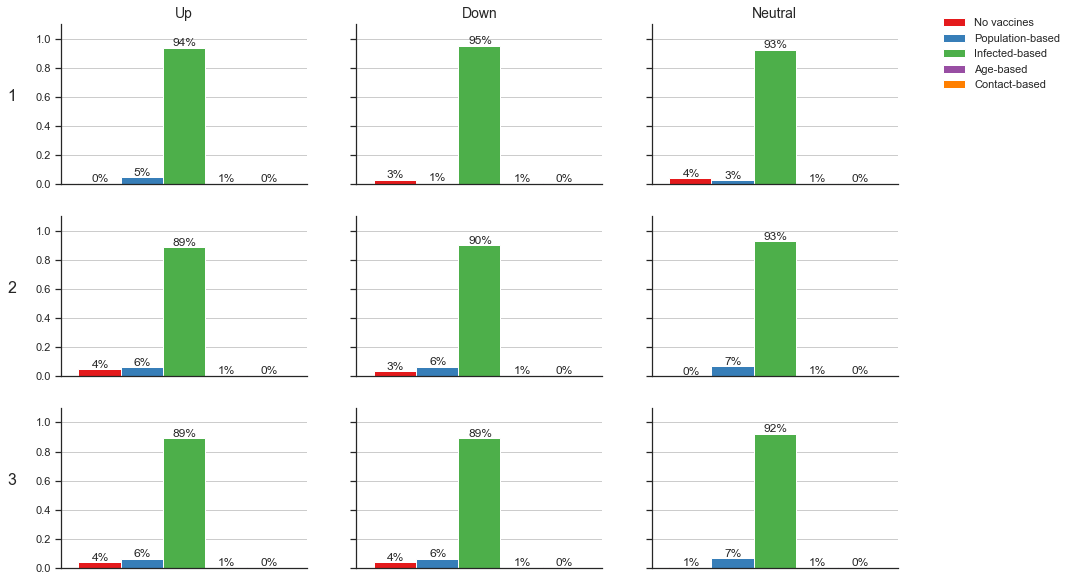

In [69]:
genes = individual.genes
plot_etp(genes, ylim=1.1)

### Population

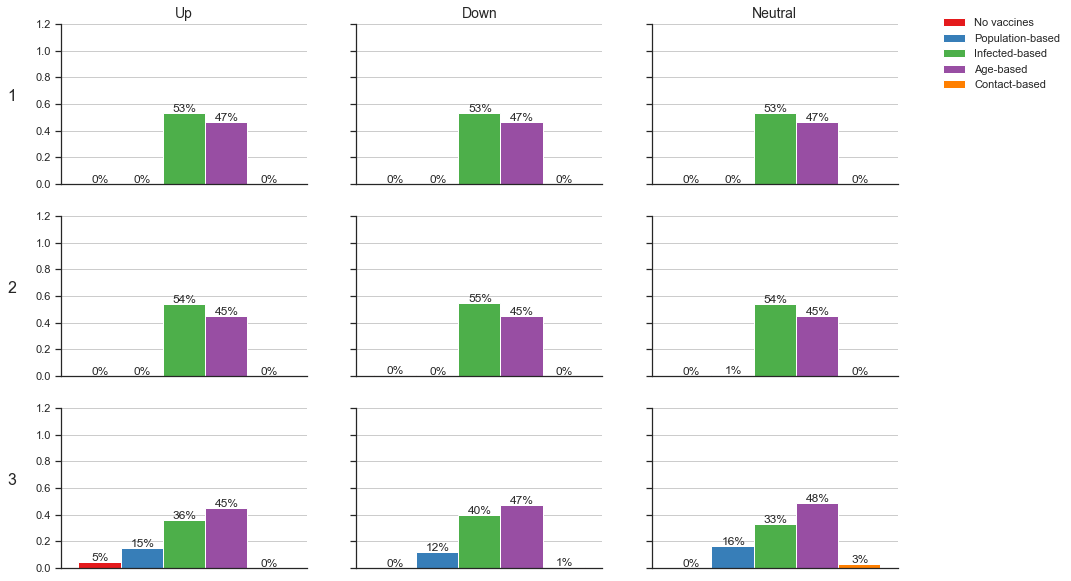

In [73]:
run = 4
num_individuals = 5
gen = runs[run_names[run]]['last_gen']

pop = utils.read_pickle(f"../results/ga/{runs[run_names[run]]['path']}/individuals/individuals_{gen}.pkl")
genes = sum(map(lambda x: x.genes, pop[:num_individuals]))/num_individuals
plot_etp(genes, ylim=1.2)

# Trend strategies

In [334]:
def plot_trend_policy_weights(ETP, ylim):
    sns.set(font_scale=1.1)
    sns.set_style("ticks")
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
    for i, run in enumerate(run_names):
        ax = axs[i//2][i%2]
        plot_policy(ax, ETP[i], ylim, legend=False)
        ax.set_title(f"Run objective: {renamer[main_objective]}", fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.43, 1.41))
    plt.show()

def get_aggregated_trend_policy(pop, trend_nr):
    ets = (sum([i.genes[trend_nr] for i in pop])/len(pop)).sum(axis=0)
    ets /= sum(ets)
    return ets

## UP

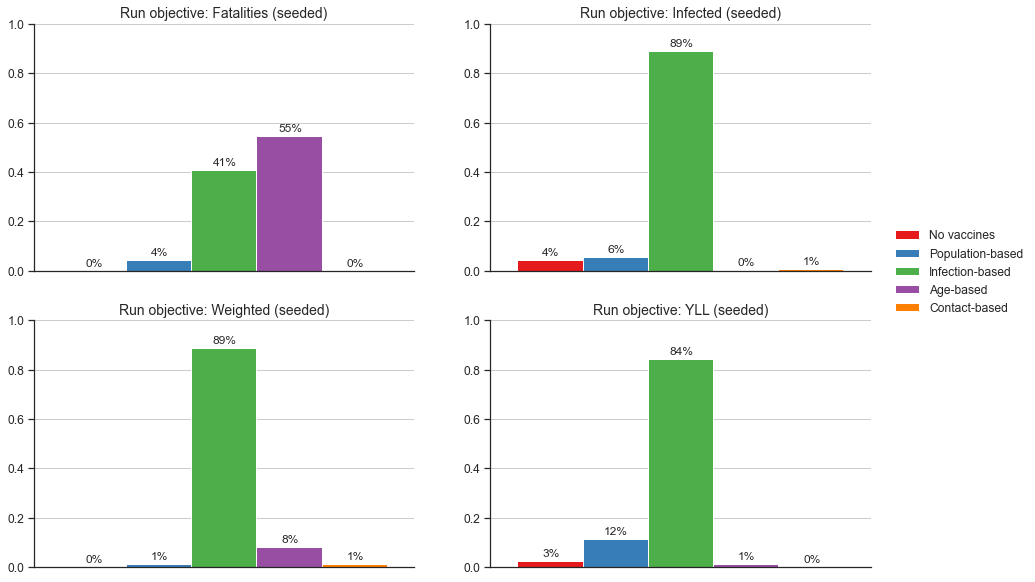

In [335]:
top_individuals = 5
up_run_1 = get_aggregated_trend_policy(pop_1[:top_individuals], 0)
up_run_2 = get_aggregated_trend_policy(pop_2[:top_individuals], 0)
up_run_3 = get_aggregated_trend_policy(pop_3[:top_individuals], 0)
up_run_4 = get_aggregated_trend_policy(pop_4[:top_individuals], 0)

plot_trend_policy_weights([up_run_1, up_run_2, up_run_3, up_run_4], ylim=1)

## DOWN

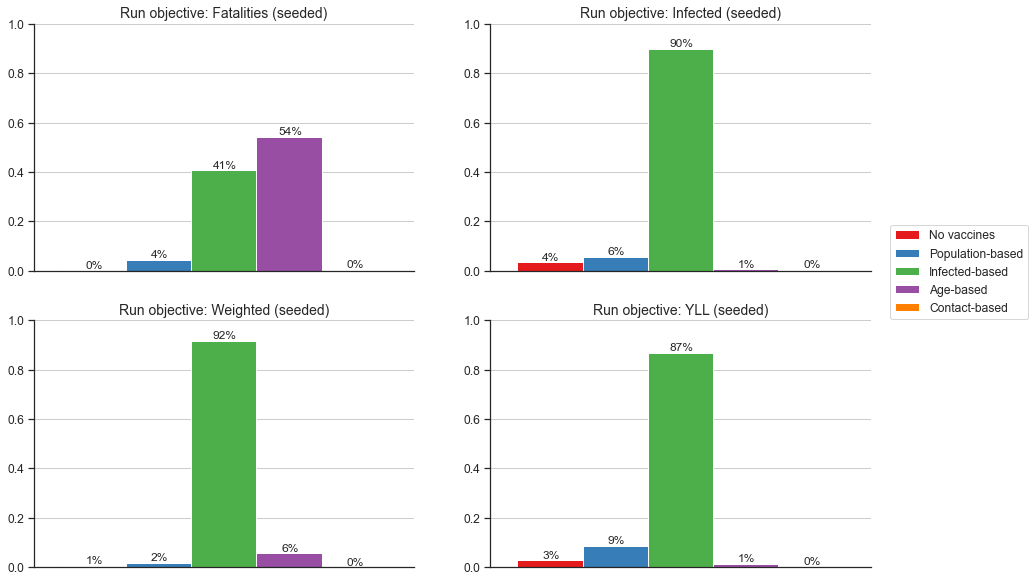

In [287]:
down_run_1 = get_aggregated_trend_policy(pop_1[:top_individuals], 1)
down_run_2 = get_aggregated_trend_policy(pop_2[:top_individuals], 1)
down_run_3 = get_aggregated_trend_policy(pop_3[:top_individuals], 1)
down_run_4 = get_aggregated_trend_policy(pop_4[:top_individuals], 1)

plot_trend_policy_weights([down_run_1, down_run_2, down_run_3, down_run_4], ylim=1)

## NEUTRAL

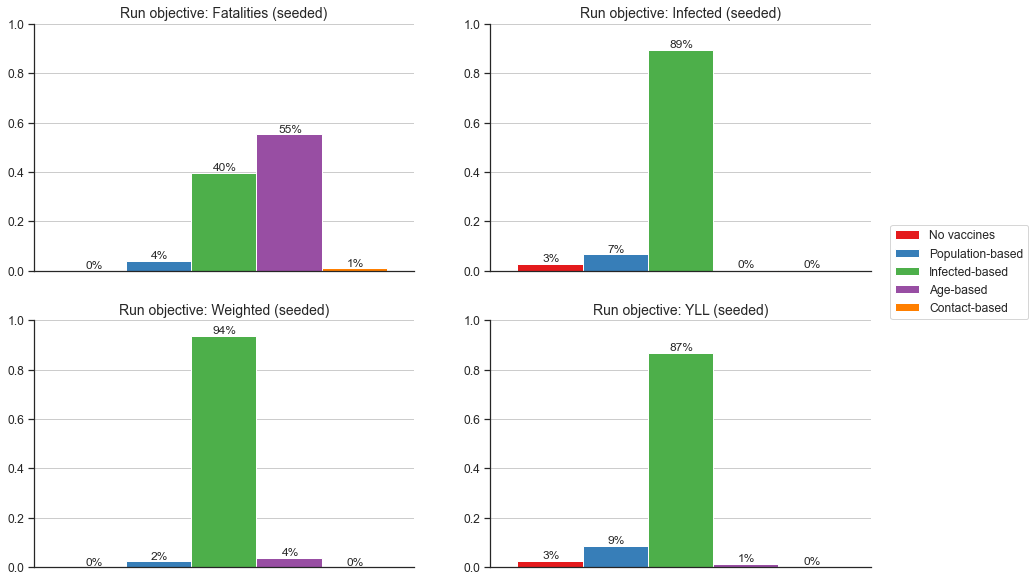

In [288]:
neutral_run_1 = get_aggregated_trend_policy(pop_1[:top_individuals], 2)
neutral_run_2 = get_aggregated_trend_policy(pop_2[:top_individuals], 2)
neutral_run_3 = get_aggregated_trend_policy(pop_3[:top_individuals], 2)
neutral_run_4 = get_aggregated_trend_policy(pop_4[:top_individuals], 2)

plot_trend_policy_weights([neutral_run_1, neutral_run_2, neutral_run_3, neutral_run_4], ylim=1)

In [336]:
def plot_all_trends_policy_weights(ETP, title, ylim):
    policies = ("No vaccines", "Population-based", "Infected-based", "Age-based", "Contact-based")
    sns.set(font_scale=1.1)
    sns.set_style("ticks")
    fig, axs = plt.subplots(ncols=3, figsize=(15,5), sharey=True)
    for i, trend in enumerate(["Up", "Down", "Neutral"]):
        ax = axs[i]
        plot_policy(ax, ETP[i], ylim, legend=False)
        ax.set_title(f"{trend}", fontsize=14)
    fig.suptitle(f"Run objective: {title.capitalize()}", y=1.01)
    plt.legend(bbox_to_anchor=(1.6, 1))
    plt.show()

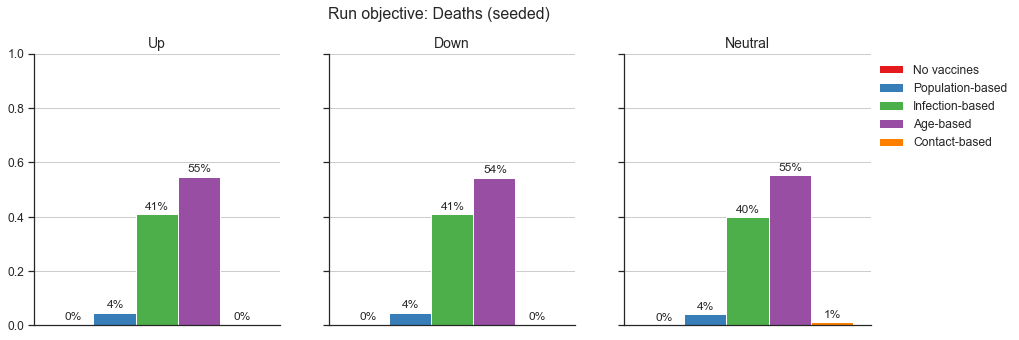

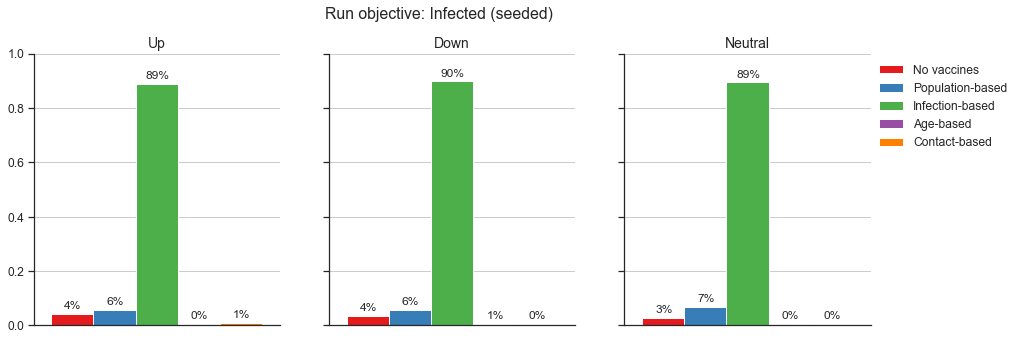

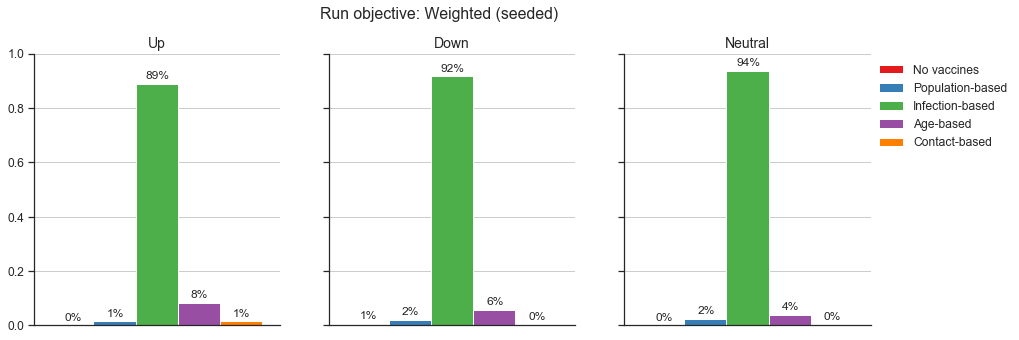

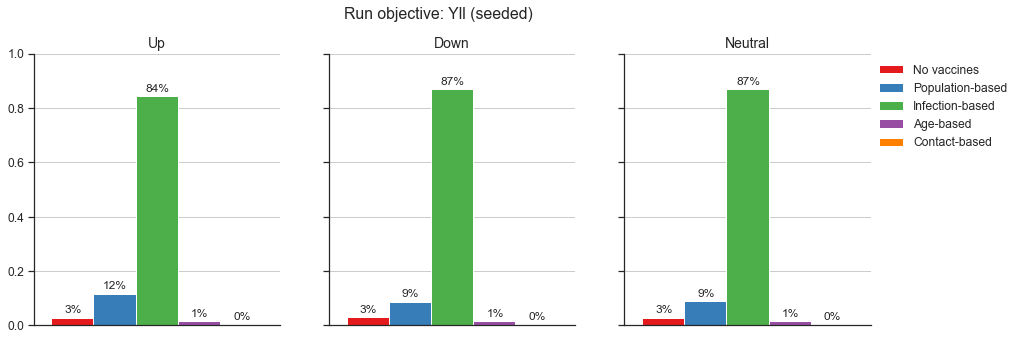

In [337]:
all_ETP = [[up_run_1, down_run_1, neutral_run_1], 
            [up_run_2, down_run_2, neutral_run_2], 
            [up_run_3, down_run_3, neutral_run_3],
            [up_run_4, down_run_4, neutral_run_4]]
run_names = [run_name_1, run_name_2, run_name_3, run_name_4]
for i, ETP in enumerate(all_ETP):
    plot_all_trends_policy_weights(ETP, title=run_names[i], ylim=1)

## Trend count strategy

In [290]:
runs = [run_1, run_2, run_3, run_4]
run_names = [run_name_1, run_name_2, run_name_3, run_name_4]
pops = [pop_1, pop_2, pop_3, pop_4]

def plot_trend_count_policy_weights(ETP, title, ylim):
    policies = ("No vaccines", "Population-based", "Infected-based", "Age-based", "Contact-based")
    sns.set(font_scale=1.1)
    sns.set_style("ticks")
    fig, axs = plt.subplots(ncols=3, figsize=(15,5), sharey=True)
    for i, trend in enumerate(["First", "Second", "Third"]):
        ax = axs[i]
        plot_policy(ax, ETP[i], ylim, legend=False)
        ax.set_title(f"{trend}", fontsize=14)
    fig.suptitle(f"Run: {title.capitalize()}", y=1.01)
    plt.legend(bbox_to_anchor=(1.6, 1))
    plt.show()

def get_trend_policy(pop, trend_nr, trend_count):
    return sum([i.genes[trend_nr][trend_count] for i in pop])/len(pop)

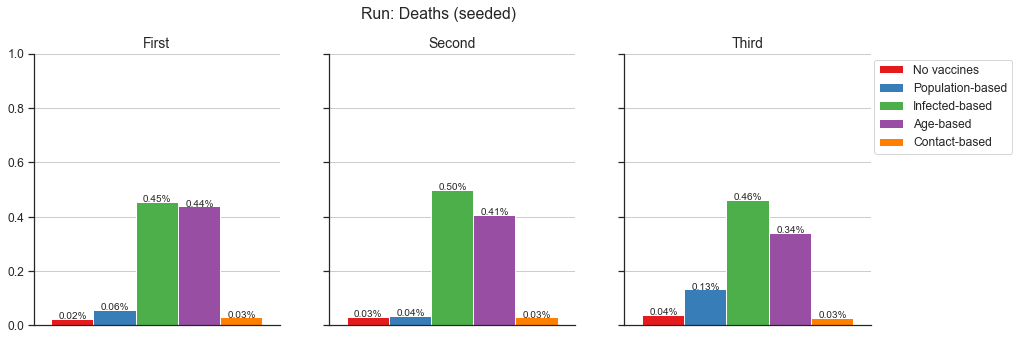

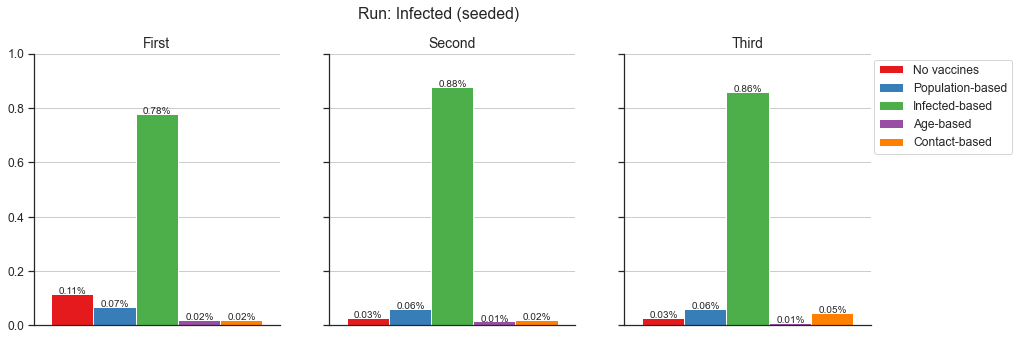

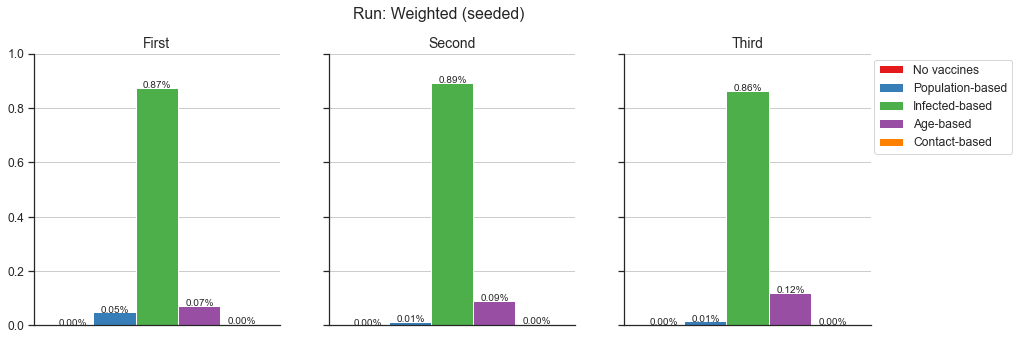

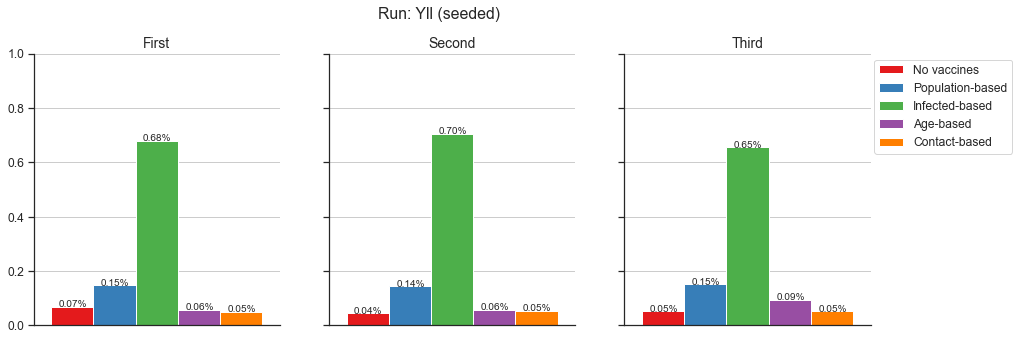

In [292]:
for i, run in enumerate(runs):
    up_1 = get_trend_policy(pops[i], 0, 0)
    up_2 = get_trend_policy(pops[i], 0, 1)
    up_3 = get_trend_policy(pops[i], 0, 2)
    plot_trend_count_policy_weights([up_1, up_2, up_3], run_names[i], 1)

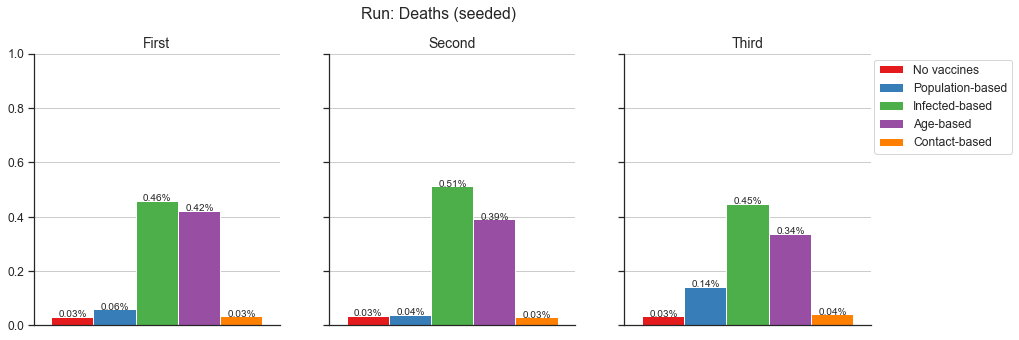

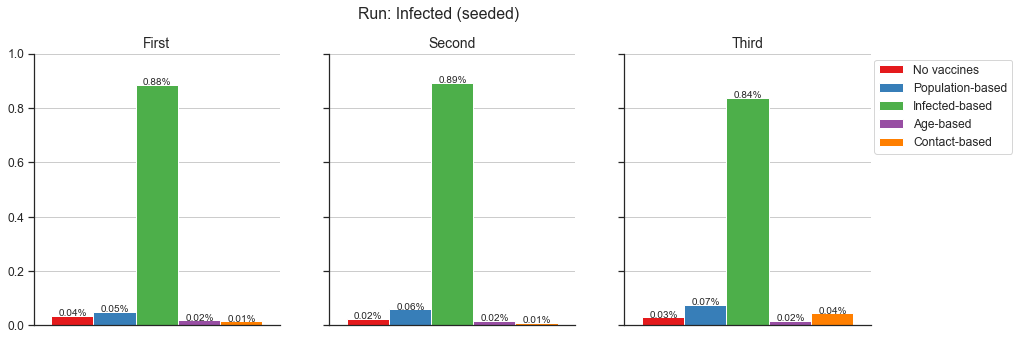

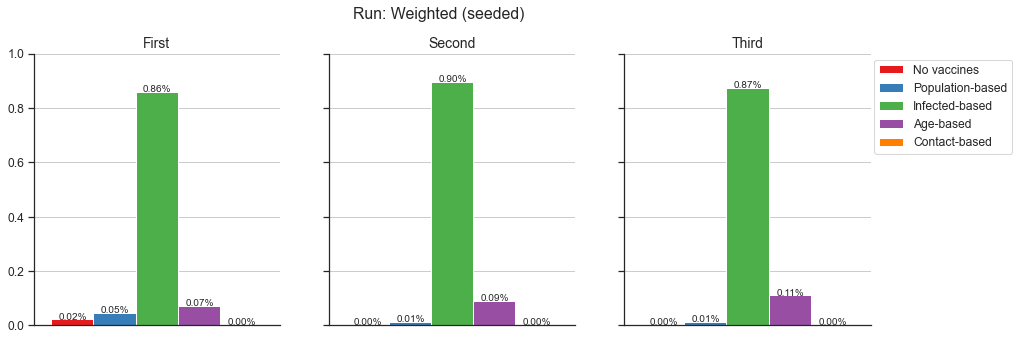

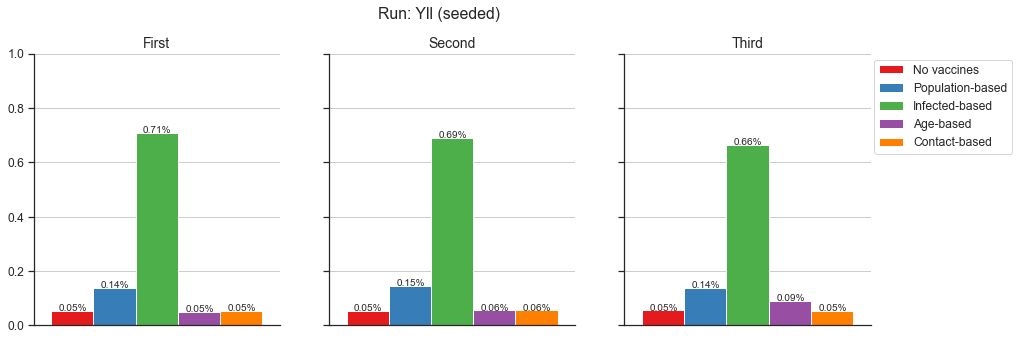

In [294]:
for i, run in enumerate(runs):
    down_1 = get_trend_policy(pops[i], 1, 0)
    down_2 = get_trend_policy(pops[i], 1, 1)
    down_3 = get_trend_policy(pops[i], 1, 2)
    plot_trend_count_policy_weights([down_1, down_2, down_3], run_names[i], 1)

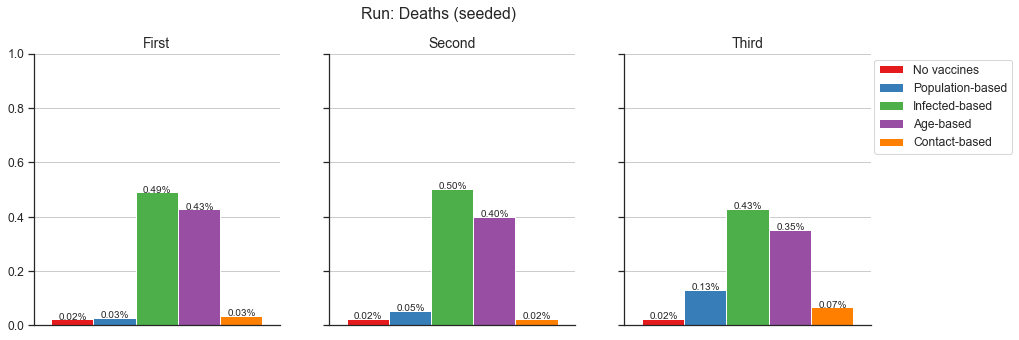

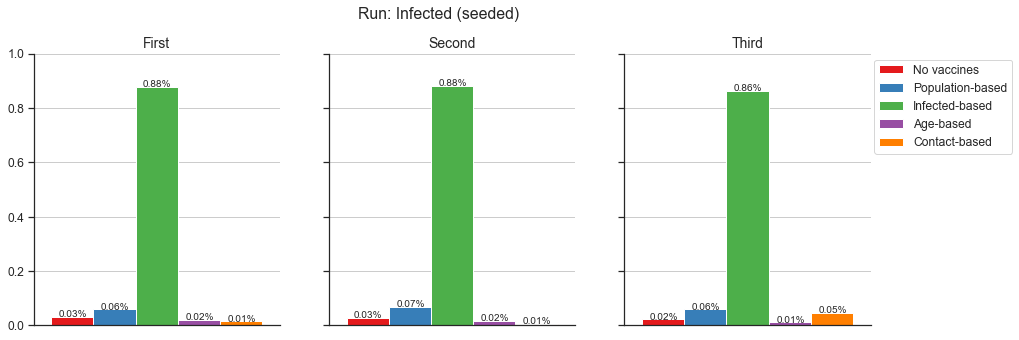

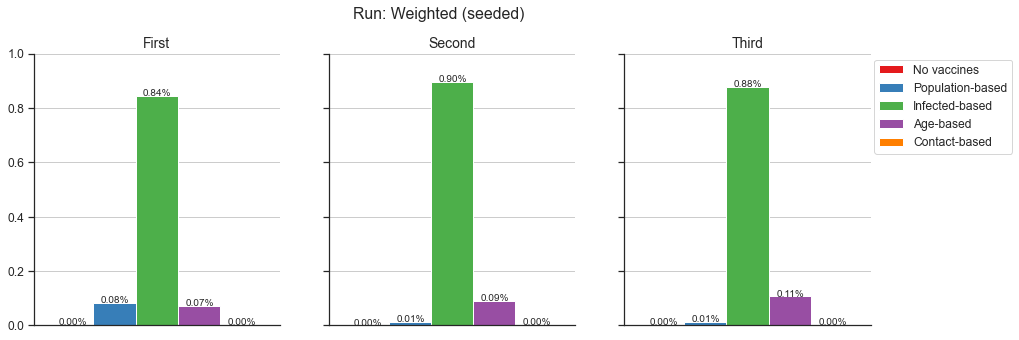

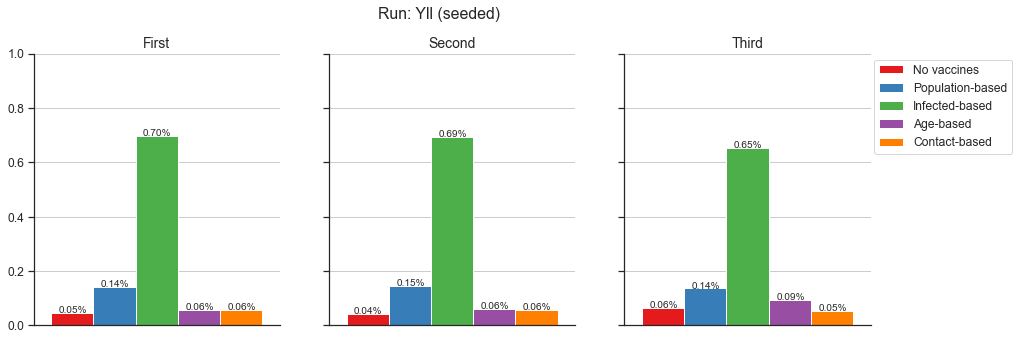

In [295]:
for i, run in enumerate(runs):
    neutral_1 = get_trend_policy(pops[i], 2, 0)
    neutral_2 = get_trend_policy(pops[i], 2, 1)
    neutral_3 = get_trend_policy(pops[i], 2, 2)
    plot_trend_count_policy_weights([neutral_1, neutral_2, neutral_3], run_names[i], 1)

## Development

In [298]:
policies = ["No vaccines", "Population-based", "Infection-based", "Age-based", "Contact-based"]
def load_generation_pop(run_nr, gen):
    individuals = utils.read_pickle(f"{dir_path + paths[run_nr-1]}/individuals/individuals_{gen}.pkl")
    return individuals

def get_generation_etp(run_nr):
    df = pd.DataFrame(columns=policies + ["Trend", "Generation"])
    for gen in range(last_gens[run_nr-1]):
        pop = load_generation_pop(run_nr, gen)
        up = get_aggregated_trend_policy(pop, 0)
        row = dict(zip(policies, up))
        row["Trend"] = "Up"
        row["Generation"] = gen
        df = df.append(row, ignore_index=True)
        down = get_aggregated_trend_policy(pop, 1)
        row = dict(zip(policies, down))
        row["Trend"] = "Down"
        row["Generation"] = gen
        df = df.append(row, ignore_index=True)
        neutral = get_aggregated_trend_policy(pop, 2)
        row = dict(zip(policies, neutral))
        row["Trend"] = "Neutral"
        row["Generation"] = gen
        df = df.append(row, ignore_index=True)
    df.set_index(["Generation", "Trend"], inplace=True)
    return df

weighted (seeded)


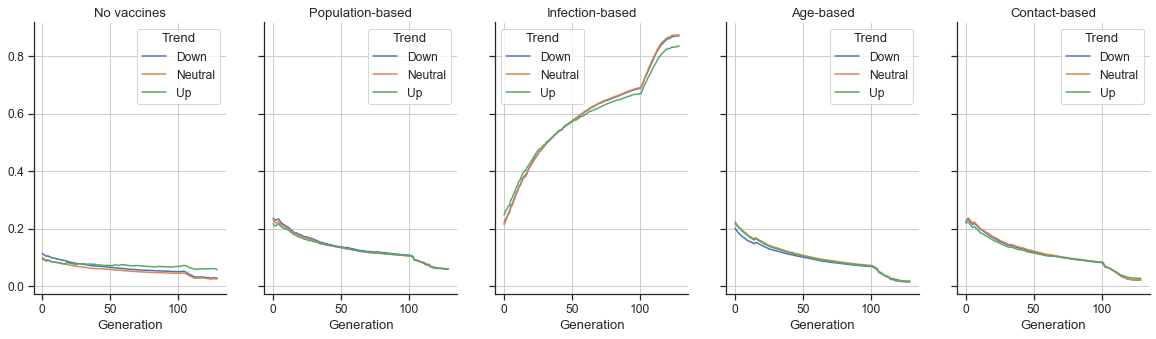

In [300]:
max_generations = 200
print(run_name_3)
df = get_generation_etp(run_2)
fig, axs = plt.subplots(ncols=5, figsize=(20,5), sharey=True)
for i, p in enumerate(policies):
    ax = axs[i]
    df.unstack(level=1)[p].plot(ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid()
    ax.set_title(p)
plt.show()

### Performance

In [382]:
runs = [run_1, run_2, run_3, run_4, run_5, run_6, run_7, run_8]
for i, name in enumerate([run_name_1, run_name_2, run_name_3, run_name_4, run_name_5, run_name_6, run_name_7, run_name_8]):
    print(f"Run {i+1}: {renamer[name]:>23}, last generation: {last_gens[runs[i]-1]}")

Run 1:     Fatalities (seeded), last generation: 185
Run 2:       Infected (seeded), last generation: 201
Run 3:       Weighted (seeded), last generation: 201
Run 4:            YLL (seeded), last generation: 183
Run 5: Fatalities (non-seeded), last generation: 165
Run 6:   Infected (non-seeded), last generation: 201
Run 7:   Weighted (non-seeded), last generation: 201
Run 8:        YLL (non-seeded), last generation: 201


In [61]:
# 0 : age_labels, 
# 1 : vaccines_available, 
# 2 : flow_scale, 
# 3 : contact_weights, 
# 4 : S_regions, 
# 5 : I_regions, 
# 6 : new_infected_regions,
# 7 : new_deaths_regions,
# 8 : V_regions,
# 9 : S_age_groups,
# 10: I_age_groups,
# 11: new_infected_age_groups,
# 12: new_deaths_age_groups,
# 13: vaccinated_age_groups,
# 14: dates
# ---------------------------
# 15: YLL

dir_path = "results/pure_policies_performance/"
policies_data = {}
policies_paths = {
    'No vaccines'      : "500_simulations_no_vaccines_2021_06_08_18_36_50",
    'Infection-Based'  : "500_simulations_infection_based_2021_06_08_12_03_15",
    'Population-Based' : "500_simulations_susceptible_based_2021_06_08_15_08_45",
    'Age-Based'        : "500_simulations_oldest_first_2021_06_08_15_08_16",
    'Contact-Based'    : "500_simulations_contact_based_2021_06_08_15_08_46",
    'NIPH'             : "500_simulations_fhi_policy_2021_06_08_15_09_27",
    'Random'           : "500_simulations_random_2021_06_08_15_45_12",
}
age_bins = [0, 17, 44, 54, 64, 74, 84]
age_labels = utils.generate_labels_from_bins(age_bins)
expected_years = utils.get_expected_yll(age_bins, age_labels)
for k, v in policies_paths.items():
    print(f"Reading results for {k} policy ...")
    data = list(utils.read_csv(dir_path+v))

    # Get YLL
    deaths_age_groups = data[12].sum(axis=1)
    yll = []
    for d in deaths_age_groups:
        sim_yll = utils.calculate_yll(expected_years, d)
        yll.append(sim_yll)
    data.append(np.array(yll))

    policies_data[k] = data

policies = list(policies_paths.keys())

Reading results for No vaccines policy ...
100%|██████████| 500/500 [00:11<00:00, 44.05it/s]
Reading results for Infection-Based policy ...
100%|██████████| 500/500 [00:05<00:00, 89.48it/s]
Reading results for Population-Based policy ...
100%|██████████| 500/500 [00:05<00:00, 83.88it/s]
Reading results for Age-Based policy ...
100%|██████████| 500/500 [00:07<00:00, 69.97it/s]
Reading results for Contact-Based policy ...
100%|██████████| 500/500 [00:05<00:00, 93.36it/s] 
Reading results for NIPH policy ...
100%|██████████| 500/500 [00:13<00:00, 37.44it/s]
Reading results for Random policy ...
100%|██████████| 500/500 [00:04<00:00, 111.50it/s]


In [158]:
dir_path = "results/results_best_individuals/"
ga_paths = {
    run_names[0]: "",
    run_names[1]: "500_simulations_infected_non_seeded_2021_06_08_01_32_42",
    run_names[2]: "500_simulations_weighted_non_seeded_2021_06_08_12_17_12",
    run_names[3]: "500_simulations_yll_non_seeded_2021_06_08_12_15_56",
    run_names[4]: "500_simulations_deaths_seeded_2021_06_08_16_23_46",
    run_names[5]: "500_simulations_infected_seeded_2021_06_08_12_13_54",
    run_names[6]: "500_simulations_weighted_seeded_2021_06_08_12_14_46",
    run_names[7]: "500_simulations_yll_seeded_2021_06_08_16_51_48",
}
ga_data = {}
age_bins = [0, 17, 44, 54, 64, 74, 84]
age_labels = utils.generate_labels_from_bins(age_bins)
expected_years = utils.get_expected_yll(age_bins, age_labels)
for run_name, path in ga_paths.items():
    try:
        print(f"Reading results for {run_name} ...")
        data = list(utils.read_csv(dir_path+path))

        # Get YLL
        deaths_age_groups = data[12].sum(axis=1)
        yll = []
        for d in deaths_age_groups:
            sim_yll = utils.calculate_yll(expected_years, d)
            yll.append(sim_yll)
        data.append(np.array(yll))

        ga_data[k] = data
    except:
        pass

Reading results for deaths (non-seeded) ...
Reading results for infected (non-seeded) ...
100%|██████████| 500/500 [00:04<00:00, 105.59it/s]
Reading results for weighted (non-seeded) ...
100%|██████████| 500/500 [00:04<00:00, 115.56it/s]
Reading results for yll (non-seeded) ...
100%|██████████| 500/500 [00:04<00:00, 109.29it/s]
Reading results for deaths (seeded) ...
100%|██████████| 500/500 [00:04<00:00, 111.74it/s]
Reading results for infected (seeded) ...
100%|██████████| 500/500 [00:05<00:00, 89.26it/s] 
Reading results for weighted (seeded) ...
Reading results for yll (seeded) ...


In [4]:
def get_mean_df(data, keys):
    obj_values = {}
    for k in keys:
        infected = data[k][11].sum(axis=2).sum(axis=1).mean()
        deaths_age_groups = data[k][12].sum(axis=1).mean(axis=0)
        yll = data[k][15].mean()
        deaths = deaths_age_groups.sum()
        weighted = 0.01 * infected + deaths

        obj_values[k] = {"Fatalities": round(deaths), "Infected": round(infected), "Weighted": round(weighted), "YLL": round(yll)}
    return pd.DataFrame(obj_values).T

In [6]:
print(get_mean_df(policies_data, policies).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  Fatalities &  Infected &  Weighted &    YLL \\
\midrule
Infection-Based  &        1443 &    168937 &      3132 &  22732 \\
Population-Based &        1888 &    211224 &      4000 &  29593 \\
Age-Based        &        1410 &    203149 &      3441 &  24122 \\
Contact-Based    &        2292 &    223082 &      4523 &  34752 \\
NIPH             &        1551 &    206593 &      3617 &  26321 \\
Random           &        1650 &    194872 &      3599 &  26347 \\
\bottomrule
\end{tabular}



In [ ]:
get_mean_df(ga_data)

In [150]:
policies_data["NIPH"][15]

319759

In [131]:
def plot_inf_vacc(new_inf, vaccinated, policy, ylim):
    fig, ax = plt.subplots(figsize=(12,5))
    ax = sns.barplot(x=np.arange(len(vaccinated)), y=vaccinated, label="Vaccinated", color="b")
    ax.set_ylabel("Vaccinated")
    ax.set_xlabel("Decision period")
    ax2 = ax.twinx()
    ax2 = sns.scatterplot(x=np.arange(len(new_inf)), y=new_inf, label="New infected", color="r")
    ax2 = sns.lineplot(x=np.arange(len(new_inf)), y=new_inf, label="New infected", color="r")
    ax2.set_ylabel("New infected")
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2[:-1], labels + labels2[:-1], loc=0)
    ax2.set_ylim(0,ylim)
    fig.suptitle(policy)
    plt.grid()
    plt.show()

def plot_infs(new_inf_1, new_inf_2):
    fig, ax = plt.subplots(figsize=(12,5))
    sns.scatterplot(x=np.arange(len(new_inf_1)), y=new_inf_1, label="New infected NIPH", color="red", ax=ax)
    sns.lineplot(x=np.arange(len(new_inf_1)), y=new_inf_1, color="red", ax=ax)
    sns.scatterplot(x=np.arange(len(new_inf_2)), y=new_inf_2, label="New infected no vaccines", color="orange", ax=ax)
    sns.lineplot(x=np.arange(len(new_inf_2)), y=new_inf_2, color="orange", ax=ax)
    ax.axvline(x=22, color="k")
    ax.set_ylabel("New infected")
    ax.set_xlabel("Decision period")
    ax.legend()
    plt.grid()
    plt.show()

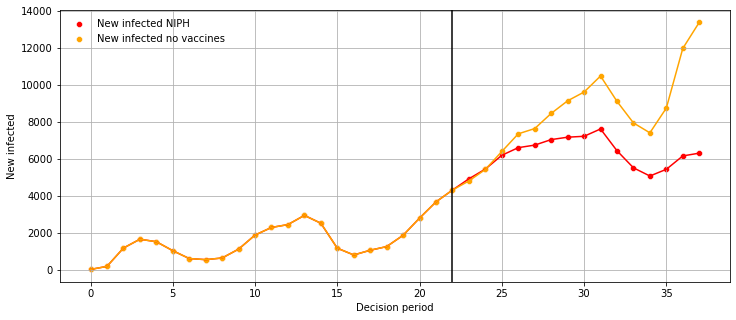

In [148]:
#for policy in ["Infection-Based", "Contact-Based", "No vaccines"]:
sim = 16
new_inf_1 = policies_data["Random"][11][sim].sum(axis=1)
new_inf_2 = policies_data["No vaccines"][11][sim].sum(axis=1)
#vaccinated = np.diff(policies_data[policy][13][-1].sum(axis=1), prepend=0)
#plot_inf_vacc(new_inf, vaccinated, policy, ylim=17000)
plot_infs(new_inf_1, new_inf_2)